# Potential vorticity

Mean and Potential Vorticity

## Theory

This could help in the eddy identification. 
The potential vorticity is defined as:
\begin{equation}
Q = \frac{1}{\rho}\zeta_a\cdot\nabla\theta
\end{equation}
where $\rho$ is the density and the absolute vorticity is
\begin{equation}
\zeta_a = 2\Omega + \nabla \times u
\end{equation}
###### I'm using the seawater package for the potential temperature abnd cosima_cookbook for parallel processing

## Calculation


In [1]:
%matplotlib inline

import cosima_cookbook as cc

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap, shiftgrid

from tqdm import tqdm_notebook

starting distributed client...
<Client: scheduler='tcp://127.0.0.1:38640' processes=8 cores=8>


In [2]:
import distributed
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:44307 Dashboard: http://127.0.0.1:43395,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [3]:
from distributed.diagnostics.progressbar import progress

We can only do this for portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.

In [4]:
@cc.memory.cache
def calc_eke(expt, box_index):
    yi, xi = box_index
   
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
    
    op = lambda p: p.isel(**box)

    u = cc.get_nc_variable(expt, 'ocean__', 'u', op=op, n=72)
    v = cc.get_nc_variable(expt, 'ocean__', 'v', op=op, n=72)
    
    temp = cc.get_nc_variable(expt, 'ocean__', 'temp', op=op, n=72)
    salt = cc.get_nc_variable(expt, 'ocean__', 'salt', op=op, n=72)
    
    u_avg = u.mean('time')
    v_avg = v.mean('time')
    
    temp_avg = temp.mean('time')
    salt_avg = salt.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = u - u_avg
    v_ = v - v_avg
    
    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    dsx.load()
        
    return dsx

In [10]:
expts=cc.expts

Since the amount

In [5]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

mom01v5/KDS75


Using 6194 ncfiles
chunking info ('time', 'st_ocean', 'yu_ocean', 'xu_ocean') [1, 7, 300, 400]



KeyError: 'geolon_c'

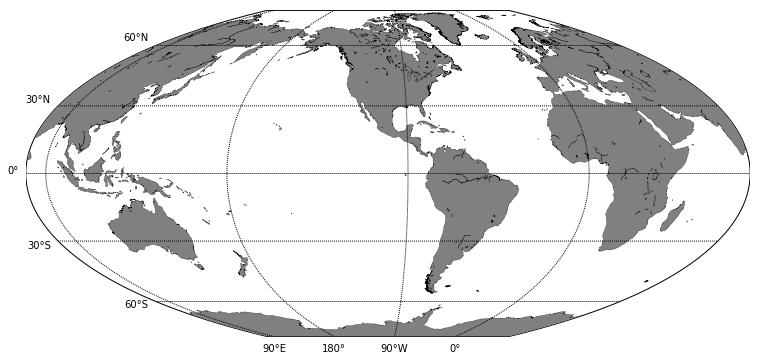

In [12]:
expt = expts[7]
print(expt)
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(expt, box_index)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE {}'.format(expt))